In [10]:
import pandas as pd
import string
import unicodedata
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
data = pd.read_csv('text_polarity.csv', encoding = "ISO-8859-1", header=None)

In [16]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [17]:
smileyfaces = [':-)', ':)', ':D', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)']
sadfaces = ['>:[', ':-(', ':(', ':-c', ':c', ':-<', ':<', ':-[', ':[', ':{', '=(','=[', 'D:']
angryfaces = ['>:(']
cryingfaces = [":’-(", ":’("]
skepticalfaces = ['>:', '>:/', ':-/', '=/',':L', '=L', ':S', '>.<']
noexpressionfaces = [':|', ':-|']
surprisedfaces = ['>:O', ':-O', ':O', ':-o', ':o', '8O', 'O_O', 'o-o', 'O_o', 'o_O', 'o_o', 'O-O']

In [28]:
def cleanText(wordSeries):
    tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                          if unicodedata.category(chr(i)).startswith('P'))
    def remove_punctuation(text):
        return text.translate(tbl)
    for smile in smileyfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(smile, ' smileyface '))
    for sad in sadfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(sad,' sadface '))
    for angry in angryfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(angry, ' angryface '))
    for cry in cryingfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(cry, ' cryingface '))
    for skeptical in skepticalfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(skeptical, ' skepticalface '))
    for noexp in noexpressionfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(noexp, ' noexpressionfaces '))
    for surprised in surprisedfaces:
        wordSeries = wordSeries.apply(lambda x: x.replace(surprised, ' surprisedface '))
    wordSeries = wordSeries.apply(lambda x: x.replace('...', ' dotdotdot '))
    wordSeries = wordSeries.apply(lambda x: x.replace('!', ' exclamatory '))
    wordSeries = wordSeries.apply(lambda x: remove_punctuation(x))
    wordSeries = wordSeries.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
    wordSeries = wordSeries.apply(lambda x: x.lower())
    wordSeries = wordSeries.apply(lambda x: x.replace('<br >',' '))
    wordSeries = wordSeries.apply(lambda x: x.replace('<br>',' '))
    wordSeries = wordSeries.apply(lambda x: x.replace('`',''))
    wordSeries = wordSeries.apply(lambda x: x.replace(' id ', ' '))
    wordSeries = wordSeries.apply(lambda x: x.replace(' im ', ' '))
    #wordSeries = wordSeries.apply(lambda x: x.replace('http', ' '))
    wordSeries = wordSeries.apply(lambda x: ' '.join( [w for w in x.split() if len(w)>1] ))
    return wordSeries

In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
def tokenize(documents):
    documents = cleanText(documents)
    docs = [word_tokenize(content) for content in documents]
    stopwords_=set(stopwords.words('english'))
    def filter_tokens(sent):
        return([w for w in sent if not w in stopwords_])
    docs=list(map(filter_tokens,docs))
    lemmatizer = WordNetLemmatizer()
    docs_lemma = [[lemmatizer.lemmatize(word) for word in words] for words in docs]
    return docs_lemma

In [33]:
data['Tokens'] = tokenize(data[5])

In [34]:
import operator
def createDict(token):
    words = {}
    for row in token:
        for word in row:
            if word in words:
                words[word] += 1
            else:
                words[word] = 1
    sorted_d = dict( sorted(words.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

In [36]:
positive = data[data[0] == 4]
negative = data[data[0] == 0]
positivewords = createDict(positive['Tokens'])
negativewords = createDict(negative['Tokens'])
words = createDict(data['Tokens'])

In [37]:
keys = [k for k in words]
vals = [v for v in words.values()]
keys_p = [k for k in positivewords]
vals_p = [v for v in positivewords.values()]
keys_n = [k for k in negativewords]
vals_n = [v for v in negativewords.values()]

In [38]:
import matplotlib.pyplot as plt

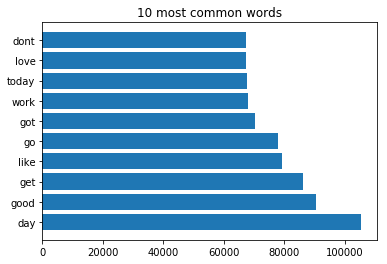

In [39]:
plt.barh(keys[2:12], vals[2:12], align='center')
plt.title("10 most common words")
plt.show()

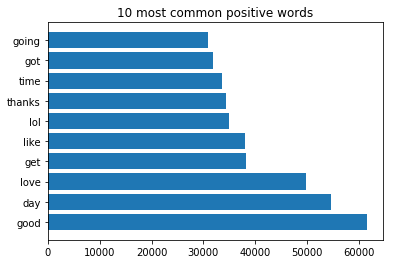

In [40]:
plt.barh(keys_p[2:12], vals_p[2:12], align='center')
plt.title("10 most common positive words")
plt.show()

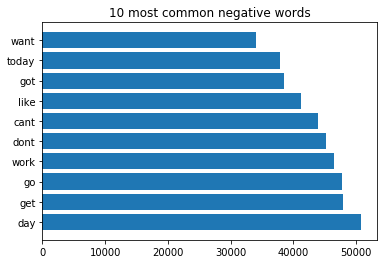

In [41]:
plt.barh(keys_n[2:12], vals_n[2:12], align='center')
plt.title("10 most common negative words")
plt.show()

In [42]:
data['tokenJ'] = data['Tokens'].apply(lambda x: ' '.join(x))
corpus = [row for row in data['tokenJ']]

In [ ]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(corpus).todense()

tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(corpus)

In [ ]:
data[0] = data[0].apply(lambda x: 1 if x == 4 else 0)

In [ ]:
X = document_tfidf_matrix
y = data[0]

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.75)

In [ ]:
lg = LogisticRegression()
lg.fit(Xtrain,ytrain)

In [ ]:
lg.score(Xtest, ytest)